In [1]:
import pandas as pd
import bert
import numpy as np
from tqdm.auto import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from bert.tokenization.bert_tokenization import FullTokenizer
import pytorch_lightning as pl
# from pytorch_lightning.metrics.functional import accuracy, f1, auroc
import torchmetrics
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format='retina'
RANDOM_SEED = 42
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
pl.seed_everything(RANDOM_SEED)

Seed set to 42


42

In [2]:
train = pd.read_csv("train.csv")
valid = pd.read_csv("valid.csv")
test = pd.read_csv("test.csv")
train = train._append(valid).reset_index(drop=True)

In [9]:
# import wget, unzip
# !wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
# !unzip uncased_L-12_H-768_A-12.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [20]:
import os
bert_ckpt_dir = 'uncased'

tokenizer = FullTokenizer(
  vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt")
)

In [24]:
tokenizer.tokenize("I can't wait to visit Bulgaria again!")

['i', 'can', "'", 't', 'wait', 'to', 'visit', 'bulgaria', 'again', '!']

In [23]:
tokens = tokenizer.tokenize("I can't wait to visit Bulgaria again!")
tokenizer.convert_tokens_to_ids(tokens)

[1045, 2064, 1005, 1056, 3524, 2000, 3942, 8063, 2153, 999]

In [25]:
#print the unique intents
train.intent.unique()

array(['PlayMusic', 'AddToPlaylist', 'RateBook', 'SearchScreeningEvent',
       'BookRestaurant', 'GetWeather', 'SearchCreativeWork'], dtype=object)

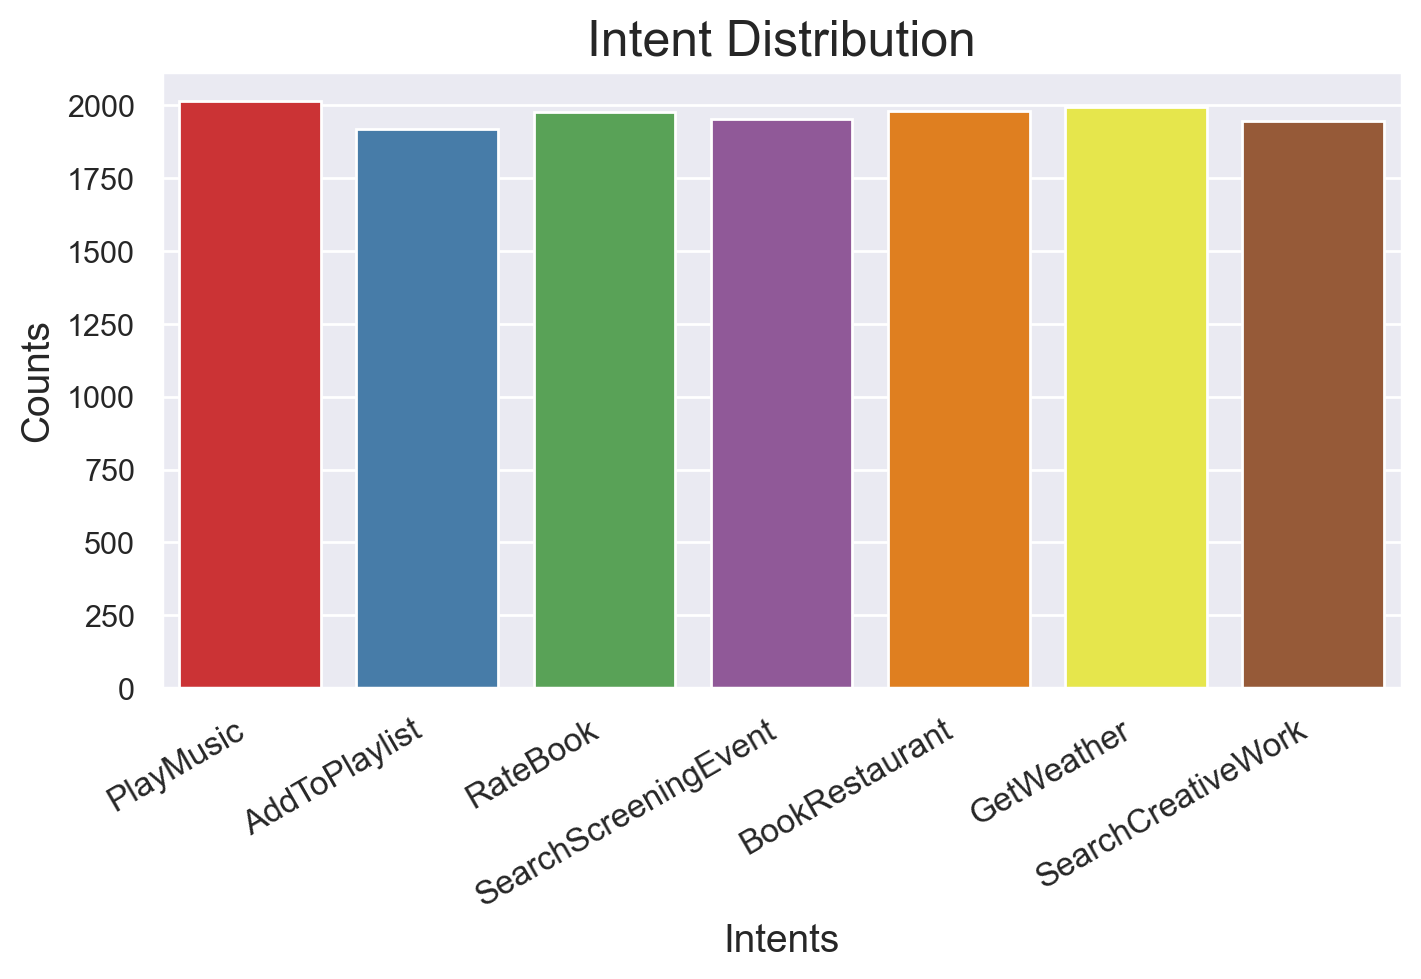

In [27]:
sns.set()
plt.figure(figsize = (8, 4))
chart = sns.countplot(x = 'intent', data = train, palette='Set1')
chart.set_xticklabels(chart.get_xticklabels(), rotation = 30, horizontalalignment='right', fontweight='light', fontsize='medium')
chart.set_title('Intent Distribution', fontsize = 18)
chart.set_xlabel('Intents', fontsize = 14)
chart.set_ylabel('Counts', fontsize = 14)
plt.show()

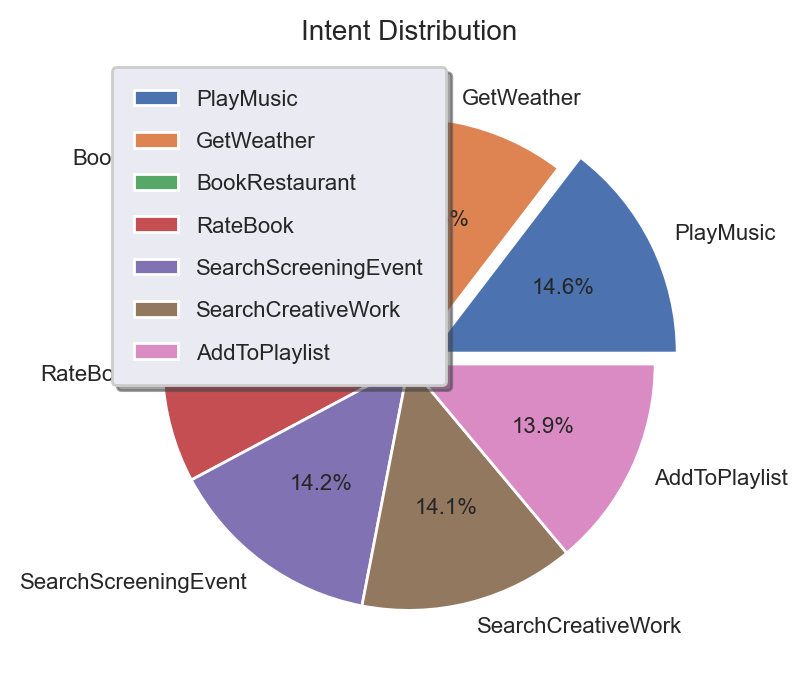

In [32]:
plt.figure(figsize= (8 , 4))
data = train.intent.value_counts()
explode = (0.1, 0, 0, 0, 0, 0, 0)

ax  = data.plot.pie(autopct = '%1.1f%%', labels = data.index, explode = explode, fontsize = 8)
ax.set_title('Intent Distribution', fontsize = 10)
plt.axis('off')
ax.legend(labels = data.index, loc = "upper left", fontsize = 8, fancybox = True, labelspacing = 1, framealpha = 1, shadow=True, borderpad=1)
plt.show()

In [33]:
import os
modelInputFolder = 'uncased'
bert_model_name="uncased_L-12_H-768_A-12"
bert_ckpt_dir = os.path.join(modelInputFolder, bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")
print(bert_ckpt_dir)
print(bert_ckpt_file)
print(bert_config_file)

uncased\uncased_L-12_H-768_A-12
uncased\uncased_L-12_H-768_A-12\bert_model.ckpt
uncased\uncased_L-12_H-768_A-12\bert_config.json


In [34]:
classes = train.intent.unique().tolist()
print(classes)

['PlayMusic', 'AddToPlaylist', 'RateBook', 'SearchScreeningEvent', 'BookRestaurant', 'GetWeather', 'SearchCreativeWork']


In [36]:
class IntentDataManager:
    def __init__(self):
        print("IntentDataManager class is called")
        pass
    pass

# Class IntentDataManager:

data = IntentDataManager()
print(data)

IntentDataManager class is called


In [38]:
max_seq_length = 192

class IntentDataManager:

    def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_length):
        # declare tokenizer and classes as a class members
        self.tokenizer = tokenizer
        self.classes = classes
        
        print(f"train shape: {train.shape}")
        print(f"test shape: {test.shape}")
        print(f"tokenizer: {self.tokenizer}")
        print(f"intent_classes: {self.classes}")
        print(f"max_seq_len: {max_seq_length}")

        pass
    pass

# Class IntentDataManager:

data = IntentDataManager(train, test, tokenizer, classes, max_seq_length)

print(data)

train shape: (13784, 2)
test shape: (700, 2)
tokenizer: <bert.tokenization.bert_tokenization.FullTokenizer object at 0x000002970D013950>
intent_classes: ['PlayMusic', 'AddToPlaylist', 'RateBook', 'SearchScreeningEvent', 'BookRestaurant', 'GetWeather', 'SearchCreativeWork']
max_seq_len: 192


In [39]:
len_of_text = train['text'].str.len()
print(len_of_text)

0        48
1        42
2        71
3        36
4        52
         ..
13779    41
13780    65
13781    50
13782    60
13783    48
Name: text, Length: 13784, dtype: int64


In [40]:
#sort text by length
sorted_indexes = len_of_text.sort_values()
print(sorted_indexes)

7713       8
10016      8
9189      10
3195      10
5452      10
        ... 
10951    136
1290     141
2674     149
2603     150
7258     186
Name: text, Length: 13784, dtype: int64


In [41]:
#Sort length of text by index
sorted_indexes = len_of_text.sort_values().index
print(sorted_indexes)

Index([ 7713, 10016,  9189,  3195,  5452,  4137,  2222, 12186, 10600,  2869,
       ...
        3324,  5670,  9992, 11405,  9919, 10951,  1290,  2674,  2603,  7258],
      dtype='int64', length=13784)


In [42]:
#pass dataframe as input in lambda function 
#sort values by length of text index
#and return the new index of sorted_indexes 
sort_by_length_text = lambda input_df: input_df.reindex( 
    input_df['text'].str.len().sort_values().index 
)
print(sort_by_length_text)

<function <lambda> at 0x000002970F867420>


In [43]:
class IntentDataManager:
    
    def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len):
        
        #declare tokenizer and classes as a class members
        self.tokenizer = tokenizer
        self.classes = classes
        
        '''
        print(f"train shape: {train.shape}")
        print(f"test shape: {test.shape}")
        print(f"tokenizer: {self.tokenizer}")
        print(f"intent_classes: {self.classes}")
        print(f"max_seq_len: {max_seq_len}")
        '''
        
        #sort train and test data by length of text
        train, test = map(sort_by_length_text, [train, test])
        
        print(f"train shape: {train.shape} \n\n {train.head()}")
        print(f"\n\ntest shape: {test.shape} \n\n {test.head()}")
        
        
        pass
    
    pass
#class IntentDataManager:
data = IntentDataManager(train, test, tokenizer, classes, max_seq_length)
print(data)

train shape: (13784, 2) 

              text              intent
7713     play pop           PlayMusic
10016    play eve           PlayMusic
9189   play zvooq           PlayMusic
3195   fimd glory  SearchCreativeWork
5452   play zvooq           PlayMusic


test shape: (700, 2) 

                   text                intent
319     find heat wave  SearchScreeningEvent
139   play jawad ahmad             PlayMusic
395   find movie times  SearchScreeningEvent
296   find movie times  SearchScreeningEvent
629  play the insoc ep             PlayMusic


In [ ]:
class IntentDataManager